In [1]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.sparse import diags
from glob import glob

In [2]:
import sys
sys.path.append('../scripts/')
from eulerian_functions import setup_AD_matrices, setup_FL_matrices, EulerianSystemParameters, velocity_vector_function
from eulerian_functions import thomas, get_rho_vectors, psi_vector_function

from eulerian_case2 import Crank_Nicolson_LHS, flux_limiter_reaction_term_function

# Case parameters

In [3]:
#### Hard-coded parameters for this case ####
# Total depth
Zmax = 50
# Simulation time
Tmax = 12*3600

# For this case, we use a speed distribution directly, taken from
# Table 3 in Sundby (1983).
# Mean speed = 0.96 mm/s
# Standard deviation = 0.38 mm/s
# Truncated at +/- 2*sigma
mean_speed = 0.0 * 1e-3
std_dev_speed = 0.38 * 1e-3
Vmin = mean_speed - 2*std_dev_speed
Vmax = mean_speed + 2*std_dev_speed
speed_distribution = lambda v: np.exp(-0.5*((v - mean_speed)/std_dev_speed)**2) / (std_dev_speed*np.sqrt(2*np.pi))
speed_distribution = lambda v: np.ones_like(v) / (4*std_dev_speed)


# Initial condition:
# Normal distribution with mean mu and standard deviation sigma
sigma_IC = 15
mu_IC = 25
pdf_IC = lambda z: np.exp(-0.5*((z - mu_IC)/sigma_IC)**2) / (sigma_IC*np.sqrt(2*np.pi))


##################################
####   Diffusivity profiles   ####
##################################

# Constant diffusivity
K_A = lambda z: 1e-3*np.ones(len(z))

# Fitted to results of GOTM simulation
#alpha, beta, zeta, z0 = (0.00636, 0.088, 1.54, 1.3)
#K_B = lambda z: alpha*(z+z0)*np.exp(-(beta*(z+z0))**zeta)
K_B = lambda z: 1e-3 + 1e-2*np.sin(z*np.pi/Zmax)



####################################################
####   Populate object with system parameters   ####
####################################################

params = EulerianSystemParameters(
        Zmax = Zmax, # Max depth of water column
        Nz = 1000, # Number of cells in z-direction
        Tmax = Tmax, # Simulation time
        dt = 300, # timestep
        Vmin = Vmin, # Minimum speed
        Vmax = Vmax, # maximum speed
        Nclasses = 3, # Number of speed classes
        speed_distribution = speed_distribution, # speed density
    )

# Obtain matrices from new code

In [4]:
# Evaluate diffusivity function at cell faces
K_vec = K_A(params.z_face)
# Arrays of velocities for all cells and all classes
v_plus = np.maximum(velocity_vector_function(params), 0)
v_minus = np.minimum(velocity_vector_function(params), 0)

# Initial concentration
C0 = pdf_IC(params.z_cell)[:,None] * params.mass_fractions[None,:]

# Set up matrices encoding advection and diffusion
# (these are tri-diagonal, and constant in time)
L_AD, R_AD = setup_AD_matrices(params, K_vec, v_minus, v_plus)
L_FL, R_FL = setup_FL_matrices(params, v_minus, v_plus, C0)

# Obtain LHS matrix from old code

In [5]:
# z_cell, dz, NJ, NK, r_sans_D, CFL_sans_v, diffusivity_vector, velocity_vector_minus, velocity_vector_plus
L_old = diags(Crank_Nicolson_LHS(
    params.z_cell,
    params.dz,
    params.Nz,
    params.Nclasses,
    params.dt/params.dz**2,
    params.dt/params.dz,
    K_vec[:,None] * np.ones((params.Nz+1, params.Nclasses)),
    v_minus,
    v_plus
), offsets = (-1, 0, 1))

# Check that the three diagonals are equal in all elements

In [6]:
for i in (-1,0,1):
    print(f'Diagonal {i:>2} matches: {np.allclose(L_AD.diagonal(i), L_old.diagonal(i))}')

print('Largest difference: ', np.amax(np.abs((L_AD - L_old).todense())))

Diagonal -1 matches: True
Diagonal  0 matches: True
Diagonal  1 matches: True
Largest difference:  0.0


# Get dot product of C and LHS flux limiter from new code

In [7]:
LHS_FL = L_FL.dot(C0.T.flatten()).reshape(params.Nclasses, params.Nz).T

# Get dot product of C and LHS flux limiter from old code

In [8]:
LHS_FL_old = flux_limiter_reaction_term_function(
    C0,
    params.Nz,
    params.Nclasses,
    params.dt/params.dz**2,
    params.dt/params.dz,
    v_minus,
    v_plus
)

# Confirm that the two dot products are equal

In [9]:
print('All elements match: ', np.allclose(LHS_FL, 0.5*LHS_FL_old))

print('Largest difference: ', np.amax(np.abs(LHS_FL - 0.5*LHS_FL_old)))

All elements match:  True
Largest difference:  3.6767317960145025e-18


# Loading and looking at results

In [10]:
profile = 'B'

# Constant diffusivity
K_A = lambda z: 1e-3*np.ones(len(z))
# Variable but symmetric diffusivity
K_B = lambda z: 1e-3 + 1e-2*np.sin(z*np.pi/Zmax)

if profile == 'A':
    K_vec = K_A(params.z_face)
else:
    K_vec = K_B(params.z_face)

C = np.load(f'../data/Case0_K_{profile}_block_Nclasses=3_NJ=1000_dt=300.npy')
print('C.shape = ', C.shape)

C.shape =  (1000, 433, 3)


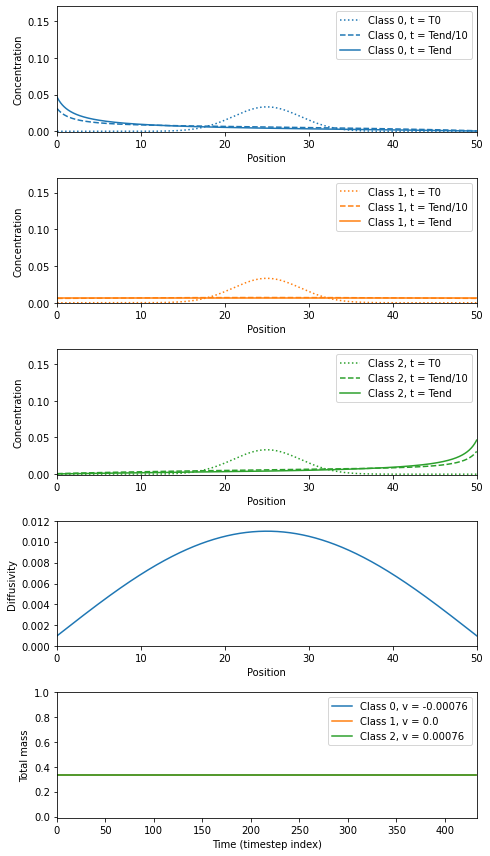

In [11]:
fig, ax = plt.subplots(nrows = 5, figsize = (7,12))

for i in (0, 1, 2):
    speeds = [-2*0.38e-3, 0.0, 2*0.38e-3]
    l, = ax[4].plot(params.dz*np.sum(C[:,:,i], axis = (0)), label = f'Class {i}, v = {speeds[i]}')
    ax[i].plot(params.z_cell, C[:,0,i], ':', c = l.get_color(), label = f'Class {i}, t = T0')
    ax[i].plot(params.z_cell, C[:,45,i], '--', c = l.get_color(), label = f'Class {i}, t = Tend/10')
    ax[i].plot(params.z_cell, C[:,-1,i], c = l.get_color(), label = f'Class {i}, t = Tend')
    ax[i].legend()
    ax[i].set_ylim(-0.001, 0.17)
    ax[i].set_xlim(0, params.Zmax)
    ax[i].set_xlabel('Position')
    ax[i].set_ylabel('Concentration')
    
ax[3].plot(params.z_face, K_vec)
ax[3].set_ylabel('Diffusivity')
ax[3].set_xlabel('Position')
ax[3].set_ylim(0.0, 0.012)
ax[3].set_xlim(0, params.Zmax)

ax[4].set_ylabel('Total mass')
ax[4].set_xlabel('Time (timestep index)')
ax[4].set_ylim(-0.01, 1)
ax[4].set_xlim(0, C.shape[1])
ax[4].legend()

plt.tight_layout()

if profile == 'A':
    plt.savefig('Symmetric_test_3_classes_constant_diffusivity.png', dpi = 240)
else:
    plt.savefig('Symmetric_test_3_classes_variable_diffusivity.png', dpi = 240)

In [9]:
A_main_old = np.load('../scripts/A_main_old.npy')
A_main_new = np.load('../scripts/A_main_new.npy')
print( np.allclose(A_main_old, A_main_new) )

A_sub_old = np.load('../scripts/A_sub_old.npy')
A_sub_new = np.load('../scripts/A_sub_new.npy')
print( np.allclose(A_sub_old, A_sub_new) )

A_sup_old = np.load('../scripts/A_sup_old.npy')
A_sup_new = np.load('../scripts/A_sup_new.npy')
print( np.allclose(A_sup_old, A_sup_new) )

True
True
True


In [4]:
A_main_new

array([ 961.00369582, 1921.00369582, 1921.00369582, ..., 3479.51591578,
       3479.51591578, 2519.51591578])

In [5]:
A_main_old

array([ 961.00369582, 1921.00369582, 1921.00369582, ..., 3479.51591578,
       3479.51591578, 2519.51591578])

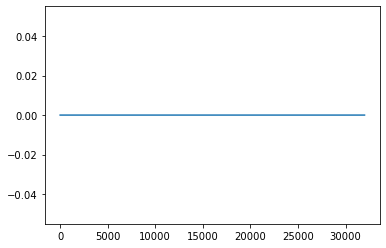

In [6]:
plt.plot(A_main_new - A_main_old)

In [51]:
FL_old = np.load('../scripts/FL_old.npy')

In [52]:
FL_old.shape

(2000, 8)

In [53]:
FL_new = np.load('../scripts/FL_new.npy')

In [54]:
FL_new.shape

(16000,)

In [55]:
np.allclose(FL_old.T.flatten(), FL_new)

False

In [56]:
np.amax(np.abs(FL_new))

0.0025182516523329923

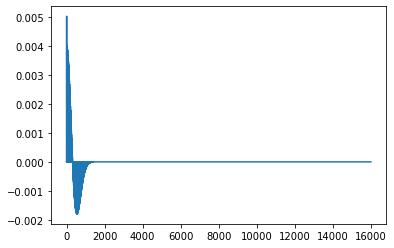

In [57]:
plt.plot(FL_old.flatten())

In [58]:
FL_old.shape

(2000, 8)

In [59]:
FL_new.shape

(16000,)

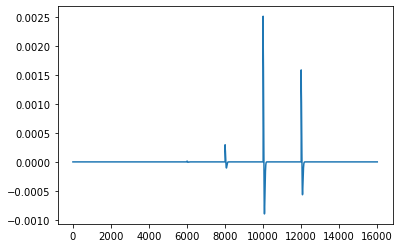

In [60]:
plt.plot(FL_new)

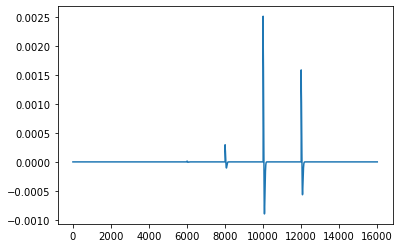

In [61]:
plt.plot(0.5*FL_old.T.flatten())

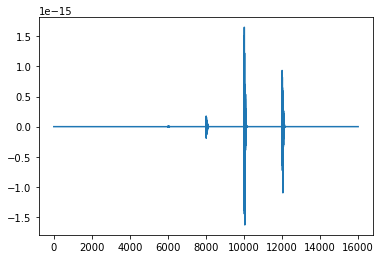

In [62]:
plt.plot(0.5*FL_old.T.flatten() - FL_new)

In [66]:
C0_new = np.load('../scripts/C0_new.npy')
C0_old = np.load('../scripts/C0_old.npy')

In [68]:
C0_new.shape, C0_old.shape

((16, 2000), (2000, 16))

In [69]:
np.allclose(C0_new, C0_old.T)

True

In [70]:
np.amax(np.abs(C0_new - C0_old.T))

2.7755575615628914e-17

In [75]:
r_new = np.load('../scripts/reaction_term_new.npy')
r_old = np.load('../scripts/reaction_term_old.npy')

print(r_new.shape, r_old.shape)

(16, 2000) (2000, 16)


In [76]:
np.allclose(r_new, r_old.T)

True

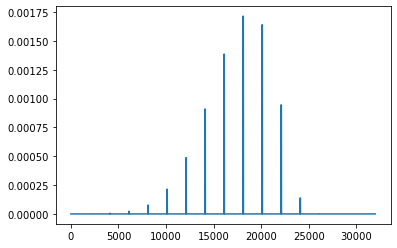

In [79]:
plt.plot(r_new.flatten())

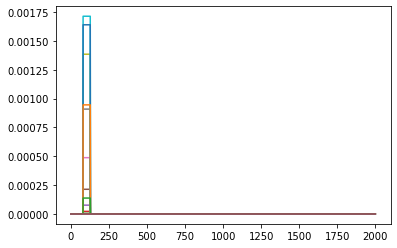

In [80]:
for i in range(16):
    plt.plot(r_new[i,:])

In [81]:
C = np.load('../debug/Case1_K_A_block_Nclasses=8_NJ=1000_dt=10.npy')

In [82]:
C.shape

(13, 8, 1000)

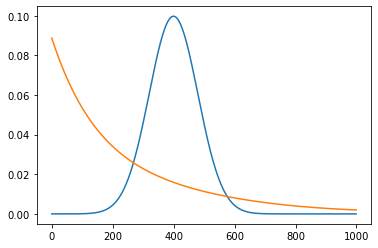

In [84]:
plt.plot(np.sum(C, axis = 1)[0,:])
plt.plot(np.sum(C, axis = 1)[-1,:])

In [2]:
C = np.load('../debug/Case1_K_A_block_Nclasses=8_NJ=8000_dt=10_old.npy')

In [37]:
C = []
for i in range(18):
    C.append(np.load(f'../scripts/C_iteration_{i}.npy'))

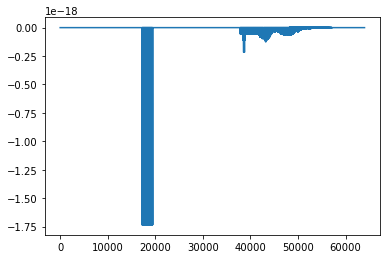

In [38]:
plt.plot((C[-1] - C[-2]).flatten())

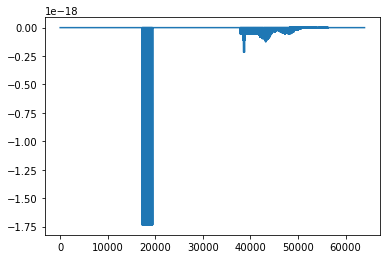

In [39]:
plt.plot((C[-3] - C[-4]).flatten())

In [40]:
diffs = []
for i in range(len(C)-1):
    diffs.append(np.amax(np.abs(C[i+1]-C[i])))

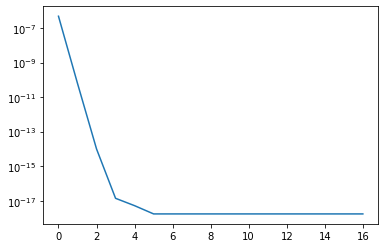

In [41]:
plt.plot(diffs)
plt.yscale('log')

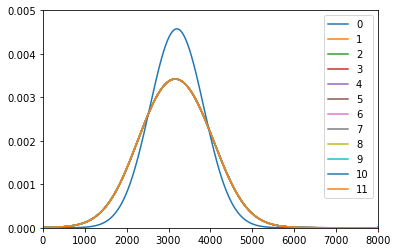

In [35]:
for i, c in enumerate(C[:12]):
    plt.plot(c.T.flatten(), label = i)
    
plt.xlim(0, 8000)
plt.ylim(0, 0.005)
plt.legend()

In [51]:
i = 16
np.argmax(np.abs(C[i+1]-C[i])), np.amax(np.abs(C[i+1]-C[i]))

(17243, 1.734723475976807e-18)

In [50]:
i = 10
np.argmax(np.abs(C[i+1]-C[i])), np.amax(np.abs(C[i+1]-C[i]))

(17243, 1.734723475976807e-18)

In [53]:
for i in range(len(C)):
    print(C[i].flatten()[17243])

0.008106169542932857
0.008106423516972336
0.008106423542220114
0.008106423542222886
0.008106423542222886
0.008106423542222884
0.008106423542222886
0.008106423542222884
0.008106423542222886
0.008106423542222884
0.008106423542222886
0.008106423542222884
0.008106423542222886
0.008106423542222884
0.008106423542222886
0.008106423542222884
0.008106423542222886
0.008106423542222884


# Debugging case 3 discrepancy

In [14]:
CgA = np.load('../tmp_results/Case3_K_A_block_Nclasses=8_NJ=1000_dt=60.0.npy')
print(CgA.shape)

zf, dz = np.linspace(0, 50, CgA.shape[-1]+1, retstep = True)
zc = zf[:-1] + dz/2

(31, 8, 1000)


20.000000213883723
18.584121821728946
17.230228766227256
16.127539782784094
15.250538092345947
14.356305431581498
13.476077095852776
12.618765283580748
11.800128342131726
11.03302688969942
10.33556324855298


(50, 0)

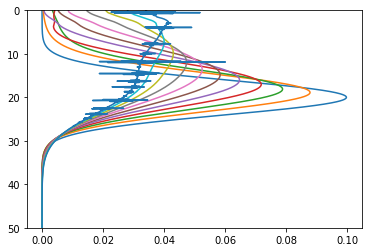

In [15]:
for it in range(11):
    plt.plot(np.sum(CgA[it,:,:], axis = 0), zc)
    print(np.sum(zc*np.sum(CgA[it,:,:], axis = 0))*dz)
    
plt.ylim(50, 0)

In [10]:
CgA = np.load('../tmp_results/Case3_K_A_block_Nclasses=8_NJ=1000_dt=120.0.npy')
print(CgA.shape)

zf, dz = np.linspace(0, 50, CgA.shape[-1]+1, retstep = True)
zc = zf[:-1] + dz/2

(31, 8, 1000)


20.000000213883723
18.591170847607213
17.252055317118074
16.1031668460792
15.193445419552063
14.377908451797834
13.501643547092204
12.616583899321029
11.815903958529496
11.067628427020448
10.362133708291584


(50, 0)

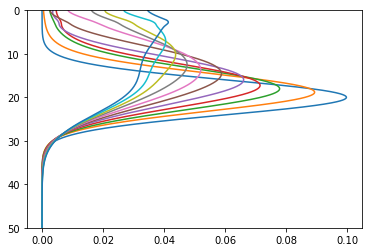

In [13]:
for it in range(11):
    plt.plot(np.sum(CgA[it,:,:], axis = 0), zc)
    print(np.sum(zc*np.sum(CgA[it,:,:], axis = 0))*dz)

plt.ylim(50, 0)

In [17]:
CgA = np.load('../../EulerLagrange-debugging-copy/results_tmp/Case3_K_A_block_Nclasses=8_NJ=1000_dt=60.npy')
print(CgA.shape)

zf, dz = np.linspace(0, 50, CgA.shape[-1]+1, retstep = True)
zc = zf[:-1] + dz/2

(361, 8, 1000)


18.584119346461616
9.783391236788605
7.281745193156806
6.75722642889194
6.406844974377002
6.158399677954401
6.003936834200182
5.93202912280416
5.930159548978376
5.9864290673649325
6.090258113085081
6.2325693317982
6.405729128130211
6.603391309674322
6.820313328885828
7.052177836080509
7.295433051028401
7.5471560256421375
7.804938397305499
8.066792380530254
8.331074118804255
8.596421527751616
8.861704033543651
9.125981968833221
9.388473755699195
9.648529339403968
9.905608632946544
10.159263970105522
10.409125759348044
10.654890710047809
10.896312116067609
11.133191795265674
11.365373363694829
11.592736586459996
11.815192602728304
12.032679862426034


(50, 0)

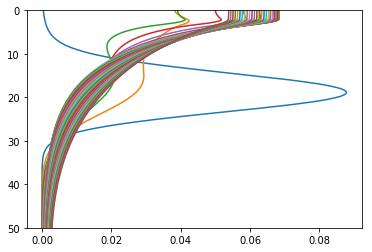

In [19]:
for it in range(1, 360, 10):
    plt.plot(np.sum(CgA[it,:,:], axis = 0), zc)
    print(np.sum(zc*np.sum(CgA[it,:,:], axis = 0))*dz)

plt.ylim(50, 0)

# Comparing equation system between new and old versions

In [50]:
RHS_old = np.load('../../EulerLagrange-debugging-copy/scripts/RHS_case3_old.npy')
RHS_new = np.load('../scripts/RHS_case3_new.npy')

#assert np.allclose(RHS_old, RHS_new)

print(np.amax(np.abs(RHS_old - RHS_new)))

0.0004901484765462288


In [51]:
LHS_old = np.load('../../EulerLagrange-debugging-copy/scripts/LHS_case3_old.npy')
LHS_new = np.load('../scripts/LHS_case3_new.npy')

assert np.allclose(LHS_old, LHS_new)

print(np.amax(np.abs(LHS_old - LHS_new)))

0.0


In [5]:
c_next_old = np.load('../../EulerLagrange-debugging-copy/scripts/c_next_case3_old.npy')
c_next_new = np.load('../scripts/c_next_case3_new.npy')

#assert np.allclose(c_next_old, c_next_new)

print(np.amax(np.abs(c_next_old - c_next_new)))

1.7010292405646166e-05


In [65]:
FL_old = np.load('../../EulerLagrange-debugging-copy/scripts/FL_term_case3_old.npy')
FL_new = np.load('../scripts/FL_term_case3_new.npy')

#assert np.allclose(RHS_old, RHS_new)

print(np.amax(np.abs(FL_old - FL_new)))

0.0004901484765462288


In [66]:
reaction_term_old = np.load('../../EulerLagrange-debugging-copy/scripts/reaction_term_case3_old.npy')
reaction_term_new = np.load('../scripts/reaction_term_case3_new.npy')

#assert np.allclose(RHS_old, RHS_new)

print(np.amax(np.abs(reaction_term_old - reaction_term_new)))

3.6408934360412404e-10


In [12]:
L_FL_old = np.load('../../EulerLagrange-debugging-copy/scripts/L_FL_old.npy')
L_FL_new = np.load('../scripts/L_FL_new.npy')

#assert np.allclose(RHS_old, RHS_new)

print(np.amax(np.abs(L_FL_old - L_FL_new)))

0.0


In [13]:
R_FL_old = np.load('../../EulerLagrange-debugging-copy/scripts/R_FL_old.npy')
R_FL_new = np.load('../scripts/R_FL_new.npy')

#assert np.allclose(RHS_old, RHS_new)

print(np.amax(np.abs(R_FL_old - R_FL_new)))

0.0


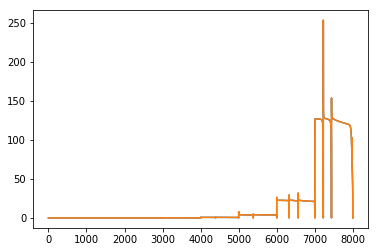

In [14]:
plt.plot(np.diagonal(L_FL_old, 1))
plt.plot(np.diagonal(L_FL_new, 1))

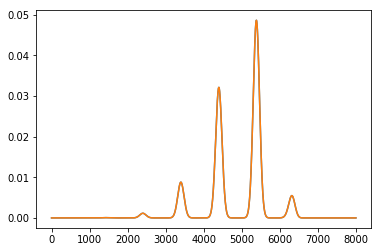

In [15]:
plt.plot(c_next_new.flatten())
plt.plot(c_next_old.flatten())

0.0


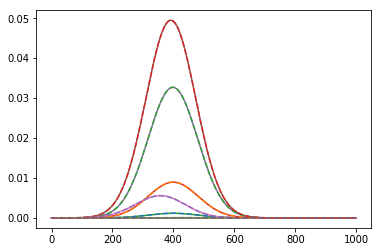

In [29]:
timestep = 1
n = 0

c_new = np.load(f'../scripts/c_now_{timestep}_{n}.npy')
c_old = np.load(f'../../EulerLagrange-debugging-copy/scripts/c_now_{timestep}_{n}.npy')

print(np.amax(np.abs(c_new - c_old)))

plt.plot(c_new.T)
plt.plot(c_old.T, '--')

3.745560909693135e-05


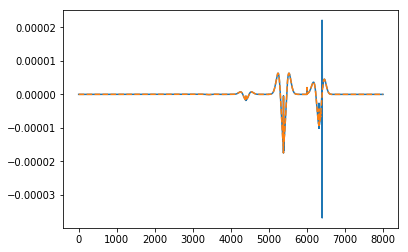

In [37]:
timestep = 1
n = 1

FL_RHS_new = np.load(f'../scripts/FL_RHS_{timestep}_{n}.npy')
FL_RHS_old = np.load(f'../../EulerLagrange-debugging-copy/scripts/FL_RHS_{timestep}_{n}.npy')

print(np.amax(np.abs(FL_RHS_new - FL_RHS_old)))

plt.plot(FL_RHS_new.T)
plt.plot(FL_RHS_old.T, '--')

0.0


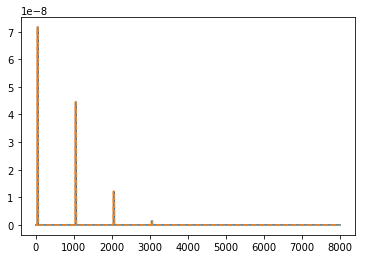

In [43]:
timestep = 1
n = 6
name = 'reaction_next'

new = np.load(f'../scripts/{name}_{timestep}_{n}.npy')
old = np.load(f'../../EulerLagrange-debugging-copy/scripts/{name}_{timestep}_{n}.npy')

print(np.amax(np.abs(new - old)))

plt.plot(new.T)
plt.plot(old.T, '--')

# Checking for discrepancy in case 3

In [15]:
tE, zE = np.loadtxt('../scripts/z_eulerian.txt', delimiter = ',').T
tL, zL = np.loadtxt('../scripts/z_lagrangian.txt', delimiter = ',').T

(0, 43200)

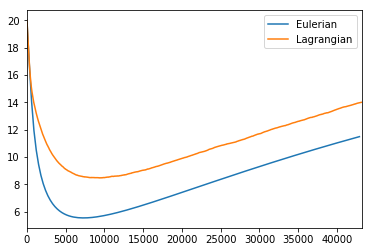

In [16]:
plt.plot(tE, zE, label = 'Eulerian') 
plt.plot(tL, zL, label = 'Lagrangian')
plt.legend()
plt.xlim(0, 12*3600)

In [25]:
V = np.load('../scripts/V.npy')

speeds_E = np.load('../scripts/speeds_E.npy')
fractions_E = np.load('../scripts/fractions_E.npy')

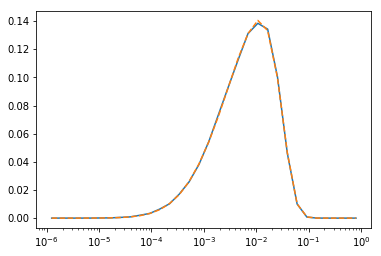

In [30]:
speed_class_edges = np.logspace(-6, 0, 33)
speeds = np.sqrt(speed_class_edges[:-1]*speed_class_edges[1:])


h, _ = np.histogram(V, speed_class_edges)

plt.plot(speeds, h / 100000)

plt.plot(-speeds_E, fractions_E, '--')

plt.xscale('log') 

In [22]:
speeds

array([1.24093776e-06, 1.91095297e-06, 2.94272718e-06, 4.53158364e-06,
       6.97830585e-06, 1.07460783e-05, 1.65481710e-05, 2.54829675e-05,
       3.92418976e-05, 6.04296390e-05, 9.30572041e-05, 1.43301257e-04,
       2.20673407e-04, 3.39820833e-04, 5.23299115e-04, 8.05842188e-04,
       1.24093776e-03, 1.91095297e-03, 2.94272718e-03, 4.53158364e-03,
       6.97830585e-03, 1.07460783e-02, 1.65481710e-02, 2.54829675e-02,
       3.92418976e-02, 6.04296390e-02, 9.30572041e-02, 1.43301257e-01,
       2.20673407e-01, 3.39820833e-01, 5.23299115e-01, 8.05842188e-01])